In [1]:
!pip install scikit-fuzzy

   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/920.8 kB ? eta -:--:--
   ---------------------- ----------------- 524.3/920.8 kB 1.4 MB/s eta 0:00:01
   ---------------------------------- ----- 786.4/920.8 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 920.8/920.8 kB 870.1 kB/s  0:00:00


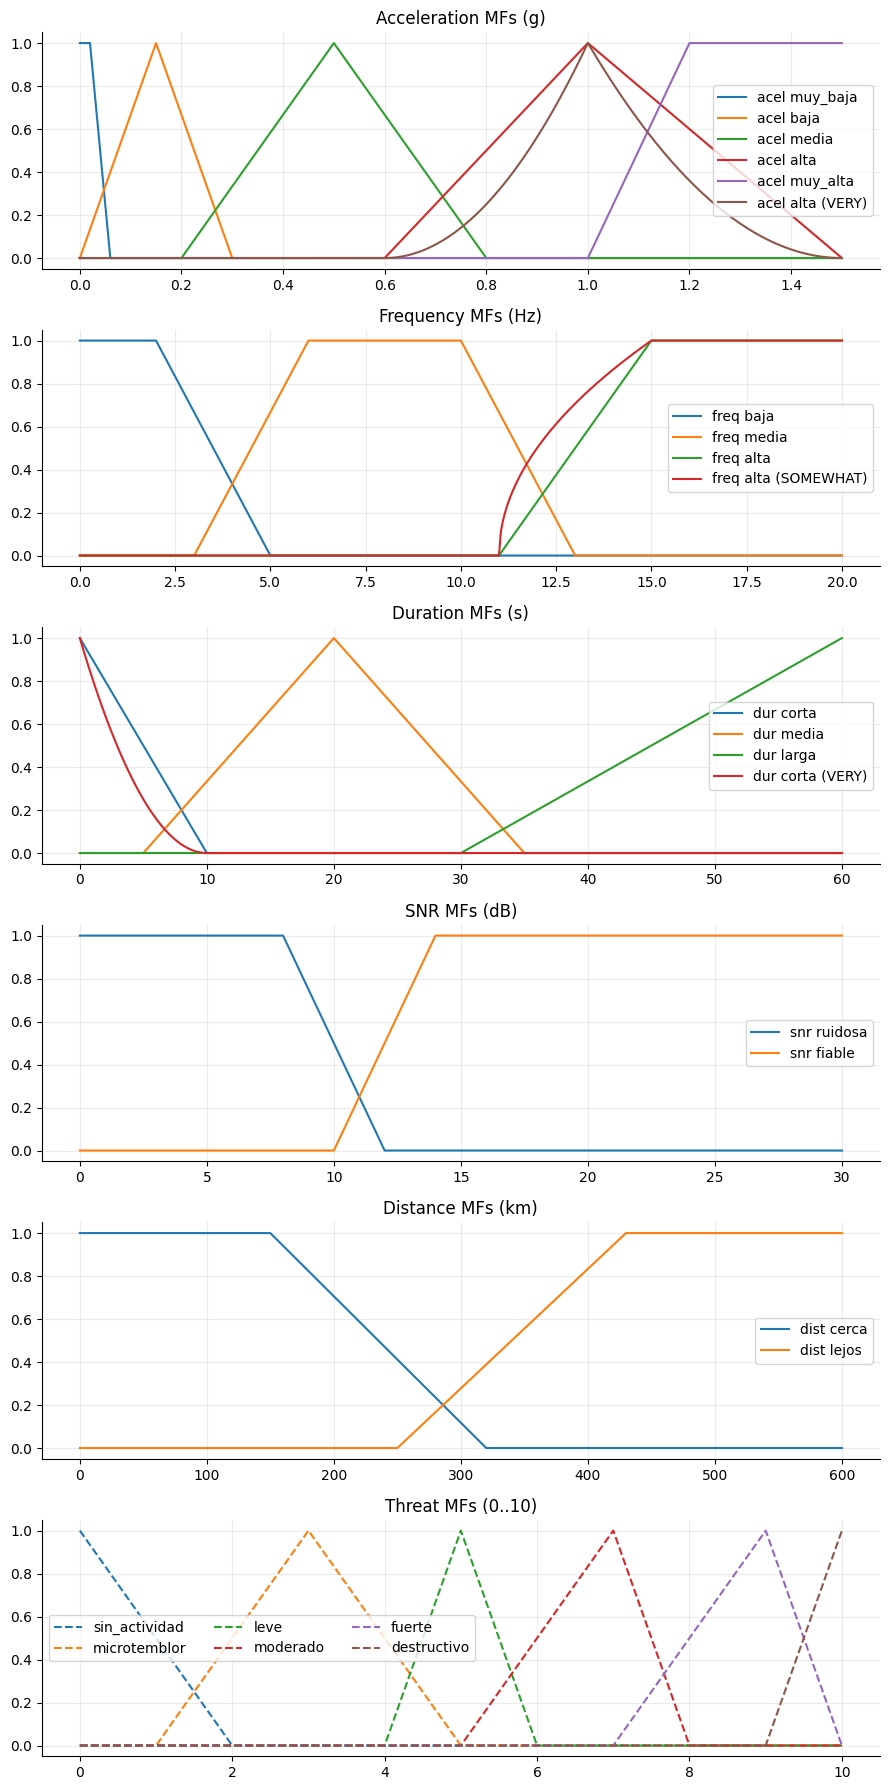

### Fuzzy Rules (Mamdani)

HTML(value="<pre style='white-space:pre-wrap'>R1  IF acel is alta AND dur is corta AND dist is cerca AND snr i…

Button(button_style='primary', description='Compute', style=ButtonStyle())

Output()

Output()

In [1]:
# ===========================================
# FUZZY EXPERT SYSTEM (MAMDANI) — EARTHQUAKE THREAT
# Structure & style aligned with the professor's examples
# - Universes of discourse
# - Membership functions
# - Linguistic labels & modifiers
# - Fuzzy rules (IF ... THEN ...)
# - Aggregation + Defuzzification (centroid by default)
# - Notebook sliders UI (ipywidgets) + CLI fallback
# ===========================================

# If running fresh in a notebook:
# !pip install -q scikit-fuzzy ipywidgets matplotlib

import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# ----------------------------
# 1) UNIVERSES OF DISCOURSE
# ----------------------------
# Inputs (kept identical to your project)
x_acel = np.linspace(0.0, 1.5, 301)   # ground acceleration (g)
x_freq = np.linspace(0.0, 20.0, 401)  # dominant frequency (Hz)
x_dur  = np.linspace(0.0, 60.0, 601)  # event duration (s)
x_snr  = np.linspace(0.0, 30.0, 301)  # SNR (dB)
x_dist = np.linspace(0.0, 600.0, 601) # epicentral distance (km)

# Output (kept identical; 0..10)
x_threat = np.linspace(0.0, 10.0, 1001)  # amenaza (0–10)

# ----------------------------------
# 2) MEMBERSHIP FUNCTIONS (MFs)
# ----------------------------------
# 2.1 Acceleration (triangles/trapezoids)
acel_muy_baja = fuzz.trapmf(x_acel, [0.00, 0.00, 0.02, 0.06])
acel_baja     = fuzz.trimf (x_acel, [0.00, 0.15, 0.30])
acel_media    = fuzz.trimf (x_acel, [0.20, 0.50, 0.80])
acel_alta     = fuzz.trimf (x_acel, [0.60, 1.00, 1.50])
acel_muy_alta = fuzz.trapmf(x_acel, [1.00, 1.20, 1.50, 1.50])

# Simple linguistic modifiers following the theory (prof’s section on labeling)
# VERY(high) → concentration (square); SOMEWHAT(high) → dilation (sqrt)
acel_alta_very = np.power(acel_alta, 2.0)

# 2.2 Frequency
freq_baja      = fuzz.trapmf(x_freq, [0.0, 0.0, 2.0, 5.0])
freq_media     = fuzz.trapmf(x_freq, [3.0, 6.0,10.0,13.0])
freq_alta      = fuzz.trapmf(x_freq, [11.0,15.0,20.0,20.0])
freq_alta_some = np.sqrt(freq_alta)  # SOMEWHAT(high) as in professor’s modifiers

# 2.3 Duration
dur_corta = fuzz.trimf (x_dur, [0.0,  0.0, 10.0])
dur_media = fuzz.trimf (x_dur, [5.0, 20.0, 35.0])
dur_larga = fuzz.trimf (x_dur, [30.0,60.0, 60.0])
dur_corta_very = np.power(dur_corta, 2.0)  # VERY(short)

# 2.4 SNR (quality of evidence)
# Use trapezoids per the professor’s style (smf/zmf replaced with traps of similar shape)
snr_ruidosa = fuzz.trapmf(x_snr, [0.0, 0.0, 8.0, 12.0])  # noisy if low SNR
snr_fiable  = fuzz.trapmf(x_snr, [10.0,14.0,30.0,30.0])  # reliable if high SNR

# 2.5 Distance
dist_cerca = fuzz.trapmf(x_dist, [0.0, 0.0,150.0,320.0])
dist_lejos = fuzz.trapmf(x_dist, [250.0,430.0,600.0,600.0])

# 2.6 Output: THREAT (amenaza) — keep the same labels
th_sin   = fuzz.trimf (x_threat, [0.0, 0.0, 2.0])   # sin_actividad
th_micro = fuzz.trimf (x_threat, [1.0, 3.0, 5.0])   # microtemblor
th_leve  = fuzz.trimf (x_threat, [4.0, 5.0, 6.0])   # leve
th_moder = fuzz.trimf (x_threat, [5.0, 7.0, 8.0])   # moderado
th_fuerte= fuzz.trimf (x_threat, [7.0, 9.0,10.0])   # fuerte
th_destr = fuzz.trimf (x_threat, [9.0,10.0,10.0])   # destructivo

# Optional diagnostic set (not used as a rule consequent; kept for labeling completeness)
th_insuf = fuzz.trimf (x_threat, [0.0, 0.0, 1.5])   # insuficiente


# -----------------------------------------------------
# 3) FUZZIFICATION HELPER (crisp → degrees per label)
# -----------------------------------------------------
def μ_acel(a):
    return {
        "muy_baja": float(fuzz.interp_membership(x_acel, acel_muy_baja, a)),
        "baja":     float(fuzz.interp_membership(x_acel, acel_baja,     a)),
        "media":    float(fuzz.interp_membership(x_acel, acel_media,    a)),
        "alta":     float(fuzz.interp_membership(x_acel, acel_alta,     a)),
        "muy_alta": float(fuzz.interp_membership(x_acel, acel_muy_alta, a)),
        "alta_very":float(fuzz.interp_membership(x_acel, acel_alta_very, a)),
    }

def μ_freq(f):
    return {
        "baja":      float(fuzz.interp_membership(x_freq, freq_baja,      f)),
        "media":     float(fuzz.interp_membership(x_freq, freq_media,     f)),
        "alta":      float(fuzz.interp_membership(x_freq, freq_alta,      f)),
        "alta_some": float(fuzz.interp_membership(x_freq, freq_alta_some, f)),
    }

def μ_dur(d):
    return {
        "corta":      float(fuzz.interp_membership(x_dur, dur_corta,      d)),
        "media":      float(fuzz.interp_membership(x_dur, dur_media,      d)),
        "larga":      float(fuzz.interp_membership(x_dur, dur_larga,      d)),
        "corta_very": float(fuzz.interp_membership(x_dur, dur_corta_very, d)),
    }

def μ_snr(s):
    return {
        "ruidosa": float(fuzz.interp_membership(x_snr, snr_ruidosa, s)),
        "fiable":  float(fuzz.interp_membership(x_snr, snr_fiable,  s)),
    }

def μ_dist(x):
    return {
        "cerca": float(fuzz.interp_membership(x_dist, dist_cerca, x)),
        "lejos": float(fuzz.interp_membership(x_dist, dist_lejos, x)),
    }

# Helper: consequents as MFs (for clipping)
THSETS = {
    "sin_actividad": th_sin,
    "microtemblor":  th_micro,
    "leve":          th_leve,
    "moderado":      th_moder,
    "fuerte":        th_fuerte,
    "destructivo":   th_destr,
    "insuficiente":  th_insuf,
}

# Label mapping for the final crisp (pick the set with max membership at the crisp)
LABEL_MAP_EN = {
    "sin_actividad": "No seismic activity",
    "microtemblor":  "Microtremor",
    "leve":          "Mild earthquake",
    "moderado":      "Moderate earthquake",
    "fuerte":        "Strong earthquake",
    "destructivo":   "Destructive earthquake",
    "insuficiente":  "Insufficient evidence",
}

def label_from_crisp(z):
    best_name, best_mu = None, -1.0
    for name, mf in THSETS.items():
        μ = float(fuzz.interp_membership(x_threat, mf, z))
        if μ > best_mu:
            best_mu, best_name = μ, name
    return LABEL_MAP_EN.get(best_name, best_name or "unknown")


# ---------------------------------------------
# 4) RULES (STYLE LIKE THE PROFESSOR: R1..R18)
# Mamdani: AND=min, OR=max, implication=clipping
# ---------------------------------------------
RULES_DOC = r"""
R1  IF acel is alta AND dur is corta AND dist is cerca AND snr is fiable                THEN amenaza is fuerte
R2  IF acel is alta AND dur is larga AND dist is cerca AND snr is fiable                THEN amenaza is destructivo
R3  IF acel is alta AND freq is alta AND dist is cerca AND snr is fiable                THEN amenaza is fuerte
R4  IF acel is alta AND dist is lejos AND snr is fiable                                 THEN amenaza is moderado
R5  IF acel is media AND freq is alta AND dist is cerca AND snr is fiable               THEN amenaza is leve
R6  IF acel is media AND dur  is media AND dist is cerca AND snr is fiable              THEN amenaza is moderado
R7  IF acel is media AND dur  is larga AND dist is cerca AND snr is fiable              THEN amenaza is moderado
R8  IF acel is baja  AND freq is alta AND dur is corta AND snr is fiable                THEN amenaza is sin_actividad
R9  IF acel is baja  AND dur  is corta AND dist is lejos AND snr is fiable              THEN amenaza is sin_actividad
R10 IF acel is baja  AND dur  is larga AND dist is cerca AND snr is fiable              THEN amenaza is microtemblor
R11 IF freq is baja AND dur  is larga AND dist is cerca AND snr is fiable               THEN amenaza is fuerte

-- noisy evidence (snr ruidosa) → conservative mapping (never above 'moderado') --
R12 IF snr is ruidosa AND acel is alta  AND dist is cerca                                THEN amenaza is moderado
R13 IF snr is ruidosa AND acel is media AND dist is cerca                                THEN amenaza is leve
R14 IF snr is ruidosa AND acel is baja                                                   THEN amenaza is microtemblor
R15 IF snr is ruidosa AND dist is lejos                                                  THEN amenaza is sin_actividad

-- general distance/effect trade-offs --
R16 IF dist is cerca AND (acel is media OR freq is alta) AND snr is fiable               THEN amenaza is moderado
R17 IF dist is lejos AND acel is baja AND dur is media AND snr is fiable                 THEN amenaza is microtemblor

-- high-intensity corner (using modifiers per theory) --
R18 IF acel is alta_very AND freq is alta_some AND dur is larga AND dist is cerca
    AND snr is fiable                                                                    THEN amenaza is destructivo
""".strip()


def mamdani_infer(acel, freq, dur, snr, dist_km, return_rule_firings=False):
    """
    Evaluate all rules manually (professor's style) and return:
      - crisp threat (centroid)
      - label in English
      - (optionally) sorted list of (μ, "R#: description") for non-zero rules
    """
    μA = μ_acel(acel)
    μF = μ_freq(freq)
    μD = μ_dur(dur)
    μS = μ_snr(snr)
    μX = μ_dist(dist_km)

    # Convenience
    min_ = np.fmin
    max_ = np.fmax

    fired = []      # (strength, label, "R# ...")
    parts = []      # list of clipped consequents to aggregate via max

    # Helper to add a rule: strength and clipped consequent
    def add_rule(strength, consequent_name, tag):
        if strength <= 0.0: 
            return
        cons = THSETS[consequent_name]
        clipped = min_(strength, cons)
        parts.append(clipped)
        fired.append((float(strength), consequent_name, tag))

    # ---- Rules (R1..R18) ----
    # R1
    r = min_(min_(min_(μA["alta"], μD["corta"]), μX["cerca"]), μS["fiable"])
    add_rule(r, "fuerte", "R1")
    # R2
    r = min_(min_(min_(μA["alta"], μD["larga"]), μX["cerca"]), μS["fiable"])
    add_rule(r, "destructivo", "R2")
    # R3
    r = min_(min_(min_(μA["alta"], μF["alta"]), μX["cerca"]), μS["fiable"])
    add_rule(r, "fuerte", "R3")
    # R4
    r = min_(min_(μA["alta"], μX["lejos"]), μS["fiable"])
    add_rule(r, "moderado", "R4")
    # R5
    r = min_(min_(min_(μA["media"], μF["alta"]), μX["cerca"]), μS["fiable"])
    add_rule(r, "leve", "R5")
    # R6
    r = min_(min_(min_(μA["media"], μD["media"]), μX["cerca"]), μS["fiable"])
    add_rule(r, "moderado", "R6")
    # R7
    r = min_(min_(min_(μA["media"], μD["larga"]), μX["cerca"]), μS["fiable"])
    add_rule(r, "moderado", "R7")
    # R8
    r = min_(min_(min_(μA["baja"], μF["alta"]), μD["corta"]), μS["fiable"])
    add_rule(r, "sin_actividad", "R8")
    # R9
    r = min_(min_(min_(μA["baja"], μD["corta"]), μX["lejos"]), μS["fiable"])
    add_rule(r, "sin_actividad", "R9")
    # R10
    r = min_(min_(min_(μA["baja"], μD["larga"]), μX["cerca"]), μS["fiable"])
    add_rule(r, "microtemblor", "R10")
    # R11
    r = min_(min_(min_(μF["baja"], μD["larga"]), μX["cerca"]), μS["fiable"])
    add_rule(r, "fuerte", "R11")

    # -- noisy SNR branch (conservative) --
    # R12
    r = min_(min_(μS["ruidosa"], μA["alta"]), μX["cerca"])
    add_rule(r, "moderado", "R12")
    # R13
    r = min_(min_(μS["ruidosa"], μA["media"]), μX["cerca"])
    add_rule(r, "leve", "R13")
    # R14
    r = min_(μS["ruidosa"], μA["baja"])
    add_rule(r, "microtemblor", "R14")
    # R15
    r = min_(μS["ruidosa"], μX["lejos"])
    add_rule(r, "sin_actividad", "R15")

    # -- distance/effect trade-offs --
    # R16: OR between (acel media) and (freq alta)
    or_term = max_(μA["media"], μF["alta"])
    r = min_(min_(min_(μX["cerca"], or_term), μS["fiable"]), 1.0)
    add_rule(r, "moderado", "R16")

    # R17
    r = min_(min_(min_(μX["lejos"], μA["baja"]), μD["media"]), μS["fiable"])
    add_rule(r, "microtemblor", "R17")

    # -- high-intensity corner with modifiers --
    # R18
    r = min_(min_(min_(min_(μA["alta_very"], μF["alta_some"]), μD["larga"]), μX["cerca"]), μS["fiable"])
    add_rule(r, "destructivo", "R18")

    # --------------------------
    # Aggregation (MAX of clips)
    # --------------------------
    if parts:
        aggregation = parts[0].copy()
        for p in parts[1:]:
            aggregation = np.fmax(aggregation, p)
    else:
        # No rule fired → all zeros
        aggregation = np.zeros_like(x_threat)

    # --------------------------
    # Defuzzification (centroid)
    # --------------------------
    try:
        crisp = float(fuzz.defuzz(x_threat, aggregation, 'centroid'))
    except Exception:
        crisp = 0.0  # degenerate case

    label = label_from_crisp(crisp)

    if return_rule_firings:
        # return top rules by strength
        fired.sort(key=lambda t: t[0], reverse=True)
        return crisp, label, aggregation, fired
    return crisp, label, aggregation


# ----------------------------------------------------
# 5) VISUALIZATION (professor-style convenience plots)
# ----------------------------------------------------
def plot_memberships():
    fig, axs = plt.subplots(6, 1, figsize=(9, 18))
    axs[0].plot(x_acel, acel_muy_baja, label='acel muy_baja')
    axs[0].plot(x_acel, acel_baja,     label='acel baja')
    axs[0].plot(x_acel, acel_media,    label='acel media')
    axs[0].plot(x_acel, acel_alta,     label='acel alta')
    axs[0].plot(x_acel, acel_muy_alta, label='acel muy_alta')
    axs[0].plot(x_acel, acel_alta_very,label='acel alta (VERY)')
    axs[0].set_title('Acceleration MFs (g)'); axs[0].legend(); axs[0].grid(alpha=0.25)

    axs[1].plot(x_freq, freq_baja,      label='freq baja')
    axs[1].plot(x_freq, freq_media,     label='freq media')
    axs[1].plot(x_freq, freq_alta,      label='freq alta')
    axs[1].plot(x_freq, freq_alta_some, label='freq alta (SOMEWHAT)')
    axs[1].set_title('Frequency MFs (Hz)'); axs[1].legend(); axs[1].grid(alpha=0.25)

    axs[2].plot(x_dur, dur_corta,      label='dur corta')
    axs[2].plot(x_dur, dur_media,      label='dur media')
    axs[2].plot(x_dur, dur_larga,      label='dur larga')
    axs[2].plot(x_dur, dur_corta_very, label='dur corta (VERY)')
    axs[2].set_title('Duration MFs (s)'); axs[2].legend(); axs[2].grid(alpha=0.25)

    axs[3].plot(x_snr, snr_ruidosa, label='snr ruidosa')
    axs[3].plot(x_snr, snr_fiable,  label='snr fiable')
    axs[3].set_title('SNR MFs (dB)'); axs[3].legend(); axs[3].grid(alpha=0.25)

    axs[4].plot(x_dist, dist_cerca, label='dist cerca')
    axs[4].plot(x_dist, dist_lejos, label='dist lejos')
    axs[4].set_title('Distance MFs (km)'); axs[4].legend(); axs[4].grid(alpha=0.25)

    axs[5].plot(x_threat, th_sin,   '--', label='sin_actividad')
    axs[5].plot(x_threat, th_micro, '--', label='microtemblor')
    axs[5].plot(x_threat, th_leve,  '--', label='leve')
    axs[5].plot(x_threat, th_moder, '--', label='moderado')
    axs[5].plot(x_threat, th_fuerte,'--', label='fuerte')
    axs[5].plot(x_threat, th_destr, '--', label='destructivo')
    axs[5].set_title('Threat MFs (0..10)'); axs[5].legend(ncol=3); axs[5].grid(alpha=0.25)

    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout(); plt.show()


def plot_aggregation(aggregation, crisp, title_note=""):
    μ_crisp = float(fuzz.interp_membership(x_threat, aggregation, crisp))
    fig, ax = plt.subplots(figsize=(9, 3.2))
    ax.plot(x_threat, th_sin,   linestyle='--', linewidth=1, label='sin_actividad')
    ax.plot(x_threat, th_micro, linestyle='--', linewidth=1, label='microtemblor')
    ax.plot(x_threat, th_leve,  linestyle='--', linewidth=1, label='leve')
    ax.plot(x_threat, th_moder, linestyle='--', linewidth=1, label='moderado')
    ax.plot(x_threat, th_fuerte,linestyle='--', linewidth=1, label='fuerte')
    ax.plot(x_threat, th_destr, linestyle='--', linewidth=1, label='destructivo')
    ax.fill_between(x_threat, 0, aggregation, alpha=0.6)
    ax.plot([crisp, crisp], [0, μ_crisp], 'k', linewidth=2, label=f'centroid = {crisp:.2f}')
    ax.set_title(f"Mamdani aggregation {title_note}"); ax.set_xlabel("Threat (0..10)"); ax.set_ylabel("μ")
    ax.legend(loc='upper left'); ax.grid(alpha=0.25)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.tight_layout(); plt.show()


# ----------------------------------------------------
# 6) NOTEBOOK SLIDERS UI (prof-style 'interactive run')
# ----------------------------------------------------
def _in_notebook():
    try:
        from IPython import get_ipython
        return get_ipython() is not None
    except Exception:
        return False

def launch_ui():
    """
    Notebook UI with sliders (keeps your original 'sliders output' requirement).
    """
    import ipywidgets as W
    from IPython.display import display, Markdown

    s_acel = W.FloatSlider(description='acc (g)', min=0.0, max=1.5, step=0.01, value=0.60, readout_format='.2f')
    s_freq = W.FloatSlider(description='freq (Hz)', min=0.0, max=20.0, step=0.1, value=4.0, readout_format='.1f')
    s_dur  = W.IntSlider  (description='dur (s)', min=0,   max=60,   step=1,   value=20)
    s_snr  = W.FloatSlider(description='SNR (dB)', min=0.0, max=30.0, step=0.1, value=18.0, readout_format='.1f')
    s_dist = W.IntSlider  (description='dist (km)', min=0,  max=600,  step=1,   value=300)

    btn    = W.Button(description='Compute', button_style='primary')
    out    = W.Output()
    rules  = W.Output()

    display(Markdown("### Fuzzy Rules (Mamdani)"))
    display(W.HTML(f"<pre style='white-space:pre-wrap'>{RULES_DOC}</pre>"))
    display(W.HBox([s_acel, s_freq]))
    display(W.HBox([s_dur, s_snr, s_dist]))
    display(btn, out, rules)

    def on_click(_):
        with out:
            out.clear_output()
            a, f, d, s, x = s_acel.value, s_freq.value, s_dur.value, s_snr.value, s_dist.value
            crisp, label, agg, fired = mamdani_infer(a, f, d, s, x, return_rule_firings=True)
            print(f"Threat (centroid): {crisp:.2f} / 10")
            print(f"Classification   : {label}")
            plot_aggregation(agg, crisp, title_note=f"(acc={a:.2f}g, f={f:.1f}Hz, dur={d}s, SNR={s:.1f}dB, dist={x}km)")

        with rules:
            rules.clear_output()
            if fired:
                print("Top firing rules:")
                for μ, cons, tag in fired[:8]:
                    print(f"  μ={μ:.3f} :: {tag}  →  {cons}")
            else:
                print("No rule fired (all antecedent degrees were zero).")

    btn.on_click(on_click)


# ----------------------------------------------------
# 7) CLI FALLBACK (if not in notebook)
# ----------------------------------------------------
def _read_float(prompt, lo, hi, default=None):
    while True:
        try:
            s = input(prompt).strip()
            if s == "" and default is not None:
                return float(default)
            v = float(s)
            if lo <= v <= hi:
                return v
        except Exception:
            pass
        print(f"Enter a number in [{lo}, {hi}]")

def run_cli():
    print("Earthquake Threat (Mamdani) — CLI")
    a = _read_float("Ground acceleration g (0..1.5): ", 0.0, 1.5)
    f = _read_float("Dominant frequency Hz (0..20): ", 0.0, 20.0)
    d = _read_float("Duration s (0..60): ", 0.0, 60.0)
    s = _read_float("SNR dB (0..30): ", 0.0, 30.0)
    x = _read_float("Distance km (0..600): ", 0.0, 600.0)
    crisp, label, agg = mamdani_infer(a, f, d, s, x)
    print(f"\nThreat (centroid): {crisp:.2f} / 10")
    print(f"Classification   : {label}")
    try:
        plot_aggregation(agg, crisp, title_note=f"(CLI)")
    except Exception:
        pass


# ----------------------------------------------------
# 8) ENTRY POINT
# ----------------------------------------------------
if __name__ == "__main__":
    if _in_notebook():
        # Show MFs once (like professor) and launch the sliders UI
        try:
            plot_memberships()
        except Exception:
            pass
        try:
            launch_ui()
        except Exception as e:
            print("Widgets UI unavailable, falling back to CLI.\n", e)
            run_cli()
    else:
        run_cli()
